In [25]:
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TRAIN_PATH = os.path.join(PROJECT_PATH, 'train')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

In [2]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


joints 순서는 아래와 같은 순서로 배치되어 저장

0 - 오른쪽 발목
1 - 오른쪽 무릎
2 - 오른쪽 엉덩이
3 - 왼쪽 엉덩이
4 - 왼쪽 무릎
5 - 왼쪽 발목
6 - 골반
7 - 가슴(흉부)
8 - 목
9 - 머리 위
10 - 오른쪽 손목
11 - 오른쪽 팔꿈치
12 - 오른쪽 어깨
13 - 왼쪽 어깨
14 - 왼쪽 팔꿈치
15 - 왼쪽 손목

In [3]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

In [4]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


In [5]:
#  하나의 annotation을 하나의 tf.train.Example로 만들어 주는 함수
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

슝=3


In [6]:
#  여러 TFRecord를 만들기
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

In [7]:
# 0이 1000개 들어 있는 리스트가 64개로 쪼개짐
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

- Ray는 병렬 처리를 위한 라이브러리
- 파이썬에서 기본적으로 제공하는 multiprocessing 패키지보다 편하게 다양한 환경에서 사용할 수 있음.=

In [8]:
# 하나의 chunk를 TFRecord로 만들어 줄 함수
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

In [9]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

In [10]:
# 데이터를 TFRecord로 만듦

num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2025-05-29 01:58:20,662	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=5.46gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

In [21]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps
    
    
    # TFRecord로 저장된 데이터를 모델 학습에 필요한 데이터로 바꿔줄 함수
    # TFRecord가 직렬화된 데이터이기 때문에 만들 때 데이터 순서와 읽어올 때 데이터 순서가 같아야 함
    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)


## StackedHourglass Network

In [12]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x


In [13]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

print('슝=3')

슝=3


In [14]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

print('슝=3')

슝=3


## stackHourglass Network

In [15]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

슝=3


## GPU가 여러 개인 환경

In [27]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = TRAIN_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

In [22]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint

train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 3
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

# 모델 학습 및 매 에포크 저장
model = StackedHourglassNetwork(
    input_shape=(256, 256, 3),
    num_stack=4,
    num_residual=1,
    num_heatmap=num_heatmap
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mse'
)

train_dataset = create_dataset(train_tfrecords, batch_size, num_heatmap, is_train=True)
val_dataset = create_dataset(val_tfrecords, batch_size, num_heatmap, is_train=False)

checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(TRAIN_PATH, 'epoch_{epoch:03d}_val{val_loss:.4f}.h5'),
    save_weights_only=False,
    save_best_only=False,
    monitor='val_loss',
    mode='min',
    verbose=1
)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[checkpoint_cb]
)


Epoch 1/3
1388/1388 [==============================] - 1288s 909ms/step - loss: 0.4443 - conv2d_1043_loss: 0.1225 - conv2d_1101_loss: 0.1114 - conv2d_1159_loss: 0.1060 - conv2d_1217_loss: 0.1044 - val_loss: 0.4071 - val_conv2d_1043_loss: 0.1034 - val_conv2d_1101_loss: 0.1019 - val_conv2d_1159_loss: 0.1011 - val_conv2d_1217_loss: 0.1007

Epoch 00001: saving model to /aiffel/aiffel/mpii/train/epoch_001_val0.4071.h5


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/3
1388/1388 [==============================] - 1257s 903ms/step - loss: 0.4038 - conv2d_1043_loss: 0.1026 - conv2d_1101_loss: 0.1013 - conv2d_1159_loss: 0.1001 - conv2d_1217_loss: 0.0998 - val_loss: 0.4019 - val_conv2d_1043_loss: 0.1021 - val_conv2d_1101_loss: 0.1008 - val_conv2d_1159_loss: 0.0987 - val_conv2d_1217_loss: 0.1003

Epoch 00002: saving model to /aiffel/aiffel/mpii/train/epoch_002_val0.4019.h5
Epoch 3/3
1388/1388 [==============================] - 1256s 903ms/step - loss: 0.3959 - conv2d_1043_loss: 0.1016 - conv2d_1101_loss: 0.0994 - conv2d_1159_loss: 0.0976 - conv2d_1217_loss: 0.0972 - val_loss: 0.3928 - val_conv2d_1043_loss: 0.1012 - val_conv2d_1101_loss: 0.0980 - val_conv2d_1159_loss: 0.0972 - val_conv2d_1217_loss: 0.0964

Epoch 00003: saving model to /aiffel/aiffel/mpii/train/epoch_003_val0.3928.h5


In [48]:
import os
import re

def extract_val_loss(model_dir, pattern):
    val_losses = []
    for filename in os.listdir(model_dir):
        match = re.match(pattern, filename)
        if match:
            epoch = int(match.group(1))
            val_loss = float(match.group(2))
            val_losses.append((epoch, val_loss))
    val_losses.sort()
    return zip(*val_losses) if val_losses else ([], [])


def visualize_validation_losses(model_dir, title="Validation Loss per Epoch", pattern =r'epoch_(\d+)_val([0-9.]+)\.h5' ):

#     pattern = pattern
#     val_losses = []

#     for filename in os.listdir(model_dir):
#         match = re.match(pattern, filename)
#         if match:
#             epoch = int(match.group(1))
#             val_loss = float(match.group(2))
#             val_losses.append((epoch, val_loss))
   

#     # 에포크 순으로 정렬
#     val_losses.sort()
    epochs, losses = extract_val_loss(model_dir, pattern)

    # 그래프 그리기
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, losses, marker='o', label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



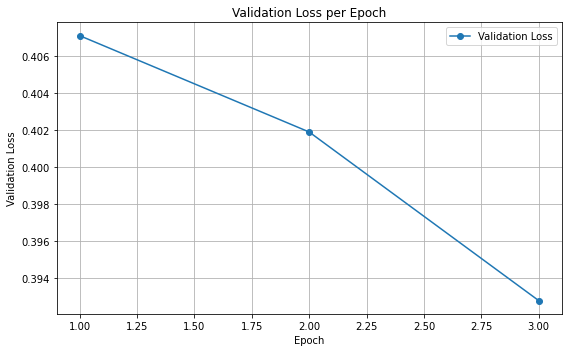

In [49]:
# loss 시각화
visualize_validation_losses(TRAIN_PATH)

In [47]:
WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'train', 'epoch_003_val0.3928.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(WEIGHTS_PATH)

In [50]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]


In [51]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

In [52]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

In [53]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [64]:
def draw_keypoints_on_image(image, keypoints, title, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    ax.set_title(title)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, title, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    ax.set_title(title)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()


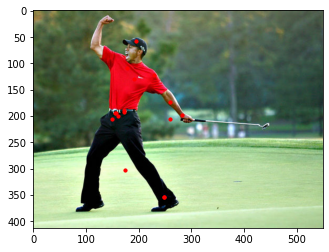

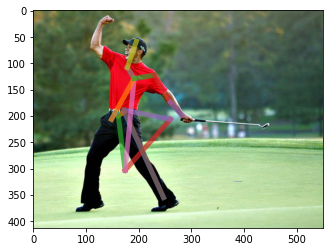

In [55]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

## simplebaseline Network

In [32]:
from tensorflow.keras import layers

# 노드학습 예시에서는 num_keypoints 가 17로 설정되어있었는데, MPII를 기반으로 학습하는 것이라면 16으로 설정해야한다고 한다.
# => stackedHourglass : num_heatmap=16 / simpleblaselin : num_keypoints=16
# 논문에서는 (input_shape=(256, 192, 3)) 였는데, stackedHourglass 와의 동일한 성능 비교를 위해 (input_shape=(256, 256, 3)) 로 변경한다.

def simplebaselineNetwork(input_shape=(256, 256, 3), num_keypoints=16):
    # ResNet-50 백본 불러오기
    backbone = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    # 백본의 입력과 출력
    inputs = backbone.input
    x = backbone.output  # 다운샘플링된 feature map (예: (8,6) 크기)

    # 3단계 업샘플링: (8×6) → (16×12) → (32×24) → (64×48)
    for _ in range(3):
        x = layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    # final_layer 키포인트 heatmap 출력
    heatmaps = layers.Conv2D(num_keypoints, kernel_size=(1,1), padding='same')(x)

    return tf.keras.Model(inputs, heatmaps, name='SimpleBaseline')


# 모델 생성 및 요약 확인
simplebaseline_model = build_simplebaseline(input_shape=(256, 192, 3), num_keypoints=16)
simplebaseline_model.summary()

# 테스트용 더미 입력
dummy_input = tf.zeros((1, 256, 192, 3))
simplebaseline_output = simplebaseline_model(dummy_input)

print("\n[SimpleBaseline 결과]")
print("출력 shape:", simplebaseline_output.shape)
print("출력 예시 (좌상 10x10x5):")
print(simplebaseline_output[0, :10, :10, :5])  # 일부만 보기



Model: "SimpleBaseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 192, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 198, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 96, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 96, 64)  256         conv1_conv[0][0]                 
_____________________________________________________________________________________

In [44]:
# simplebaseline 모델 학습 및 매 에포크 저장
simplebaseline_model = simplebaselineNetwork(input_shape=(256, 256, 3), num_keypoints=16)

simplebaseline_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mse'
)

simplebaseline_train_dataset = create_dataset(train_tfrecords, batch_size, num_heatmap, is_train=True)
simplebaseline_val_dataset = create_dataset(val_tfrecords, batch_size, num_heatmap, is_train=False)

checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(TRAIN_PATH, 'epoch_{epoch:03d}_val_simplebaseline_{val_loss:.4f}.h5'),
    save_weights_only=False,
    save_best_only=False,
    monitor='val_loss',
    mode='min',
    verbose=1
)

simplebaseline_model.fit(
    simplebaseline_train_dataset,
    validation_data=simplebaseline_val_dataset,
    epochs=epochs,
    callbacks=[checkpoint_cb]
)


Epoch 1/3
1388/1388 [==============================] - 703s 499ms/step - loss: 0.1033 - val_loss: 0.0941

Epoch 00001: saving model to /aiffel/aiffel/mpii/train/epoch_001_val_simplebaseline_0.0941.h5
Epoch 2/3
1388/1388 [==============================] - 689s 494ms/step - loss: 0.0883 - val_loss: 0.0857

Epoch 00002: saving model to /aiffel/aiffel/mpii/train/epoch_002_val_simplebaseline_0.0857.h5
Epoch 3/3
1388/1388 [==============================] - 680s 488ms/step - loss: 0.0813 - val_loss: 0.0806

Epoch 00003: saving model to /aiffel/aiffel/mpii/train/epoch_003_val_simplebaseline_0.0806.h5


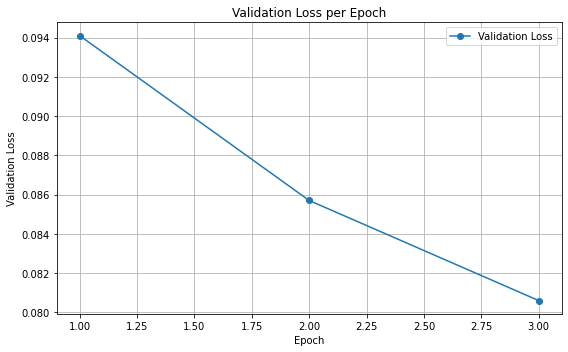

In [66]:
# loss 시각화
visualize_validation_losses(TRAIN_PATH,pattern =r'epoch_(\d+)_val_simplebaseline_([0-9.]+)\.h5')

In [58]:
SIMPLEBASELINE_WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'train', 'epoch_003_val_simplebaseline_0.0806.h5')

simplebaseline_model = simplebaselineNetwork(IMAGE_SHAPE, 16)
simplebaseline_model.load_weights(SIMPLEBASELINE_WEIGHTS_PATH)

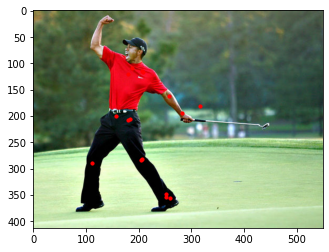

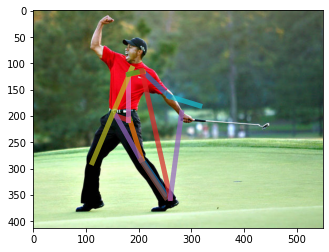

In [59]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(simplebaseline_model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

## stackedHourglass 와 simplebaseline 정량적 비교

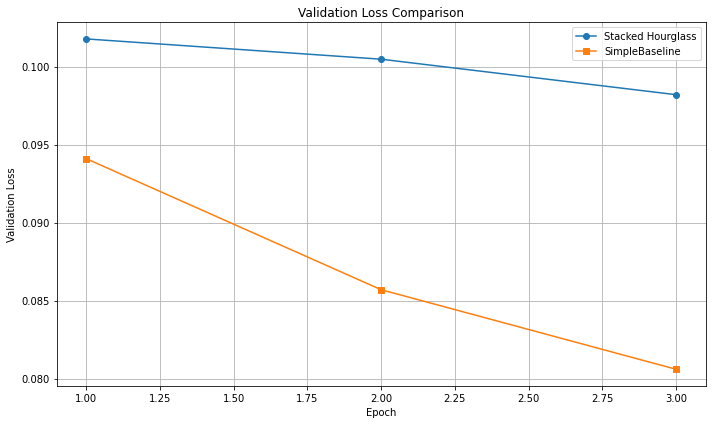

In [60]:
def compare_val_losses(model_dir):
    # 정규표현식 패턴
    pattern_hourglass = r'epoch_(\d+)_val([0-9.]+)\.h5'
    pattern_simplebaseline = r'epoch_(\d+)_val_simplebaseline_([0-9.]+)\.h5'

    # 데이터 추출
    epochs_hg, val_losses_hg = extract_val_loss(model_dir, pattern_hourglass)
    epochs_sb, val_losses_sb = extract_val_loss(model_dir, pattern_simplebaseline)
    
    # Hourglass loss 4로 나누기
    if val_losses_hg:
        val_losses_hg = [loss / 4.0 for loss in val_losses_hg]

    # 그래프 시각화
    plt.figure(figsize=(10, 6))
    if val_losses_hg:
        plt.plot(epochs_hg, val_losses_hg, marker='o', label='Stacked Hourglass')
    if val_losses_sb:
        plt.plot(epochs_sb, val_losses_sb, marker='s', label='SimpleBaseline')
    plt.title("Validation Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 실행
compare_val_losses(TRAIN_PATH)

### Metric :  PCK (Percentage of Correct Keypoints)
- 정의: 예측한 keypoint가 정답 위치에서 일정 거리(예: 0.05 * head size) 안에 들어왔는지를 기준으로 정확도를 측정
- 간단하고 직관적이며, MPII 기준 평가에 적합

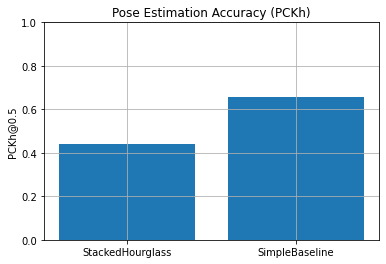

StackedHourglass PCKh@0.5: 0.4387279748916626
SimpleBaseline PCKh@0.5: 0.6563346982002258


In [69]:
def calc_pckh_tf(preds, gts, head_lengths, threshold=0.5):
    preds = tf.cast(preds, tf.float32)
    gts = tf.cast(gts, tf.float32)
    head_lengths = tf.cast(head_lengths, tf.float32)

    dists = tf.norm(preds - gts, axis=-1)  # (B, K)
    threshold_dists = tf.expand_dims(head_lengths * threshold, axis=1)
    correct = tf.cast(dists < threshold_dists, tf.float32)
    return tf.reduce_sum(correct) / tf.size(correct, out_type=tf.float32)

def get_max_preds_from_heatmaps(heatmaps):
    B, H, W, K = heatmaps.shape
    reshaped = tf.reshape(heatmaps, (B, H * W, K))
    coords = tf.argmax(reshaped, axis=1)
    coords = tf.cast(coords, tf.int32)
    x = coords % W
    y = coords // W
    return tf.stack([x, y], axis=-1)

def evaluate_model_pck(model, dataset, head_threshold=0.5):
    preds_all, gts_all, head_sizes = [], [], []

    for images, heatmaps in dataset:
        gt_coords = get_max_preds_from_heatmaps(heatmaps).numpy()
        preds_heatmaps = model(images, training=False)
        if isinstance(preds_heatmaps, list):
            preds_heatmaps = preds_heatmaps[-1]
        pred_coords = get_max_preds_from_heatmaps(preds_heatmaps).numpy()

        head_size = np.linalg.norm(gt_coords[:, 8, :] - gt_coords[:, 9, :], axis=-1)

        preds_all.append(pred_coords)
        gts_all.append(gt_coords)
        head_sizes.append(head_size)

    preds_all = np.concatenate(preds_all, axis=0)
    gts_all = np.concatenate(gts_all, axis=0)
    head_sizes = np.concatenate(head_sizes, axis=0)

    return float(calc_pckh_tf(preds_all, gts_all, head_sizes, threshold=head_threshold))

# 예시 실행 코드 (사용 전 반드시 모델과 dataset이 정의되어 있어야 함)
hg_pck = evaluate_model_pck(model, val_dataset)  # StackedHourglass 모델
sb_pck = evaluate_model_pck(simplebaseline_model, simplebaseline_val_dataset)  # SimpleBaseline 모델

plt.bar(["StackedHourglass", "SimpleBaseline"], [hg_pck, sb_pck])
plt.ylabel("PCKh@0.5")
plt.title("Pose Estimation Accuracy (PCKh)")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

print("StackedHourglass PCKh@0.5:", hg_pck)
print("SimpleBaseline PCKh@0.5:", sb_pck)


## stackedHourglass 와 simplebaseline 정성적 비교

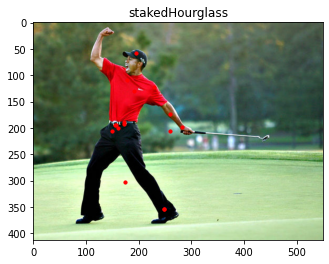

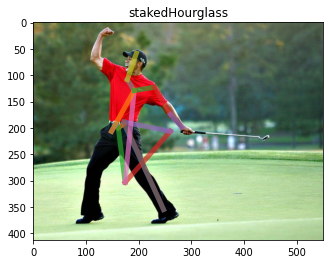

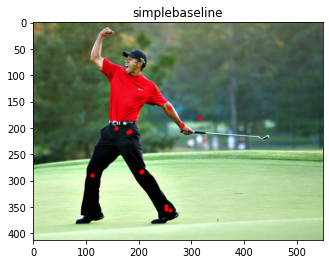

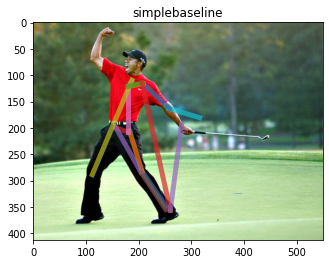

In [65]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
simplebaseline_image, simplebaseline_keypoints = predict(simplebaseline_model, test_image)
draw_keypoints_on_image(image, keypoints, title='stakedHourglass')
draw_skeleton_on_image(image, keypoints, title='stakedHourglass')
draw_keypoints_on_image(simplebaseline_image, simplebaseline_keypoints,title='simplebaseline')
draw_skeleton_on_image(simplebaseline_image, simplebaseline_keypoints,title='simplebaseline')

## 결론
- 모델 관점에서 보았을 때, stackedHourglass 는 과도하게 시간이 많이 들어가고 구조도 복잡하여 드는 공수가 많았음에도 불구하고 정량적 지표기준으로 보았을 때 simplebaseline보다 성능이 좋지 않았다.
- 해당 데이터에서는 simplebaseline 모델을 선택해서 학습하는 것이 적합하다는 결론을 얻었다.

## 회고 
배운점 : simplebaseline 과 stackHourGlass 를 직접 구현해 봤다는 부분이 신기했다. 구조적인 부분도 비교하는데 하나하나 공부할 수 있어서 좋았다.
아쉬운 점 : 에포크를 3밖에 돌리지 못해서 그런지, 사진의 스켈레톤이 두 모델 모두 이상하다...ㅠㅠ 시간이 되면 에포크를 더 돌리고 싶다.